In [13]:
import torch
import torchvision.datasets
import torchvision.models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm
from train_utils import get_data_loaders, train, test
from PIL import Image
import pandas as pd
from convnet import ConvNet

In [14]:
root = './distilled_dataset'

### CIFAR10 Distilled

In [15]:
class CIFAR10_Distilled(Dataset):
    def __init__(self, idx_df, transform):
        self.idx_df = idx_df
        self.transform = transform
    
    def __len__(self):
        return len(self.idx_df)

    def __getitem__(self, index):
        entry = self.idx_df.iloc[index]
        image = self.transform(Image.open(entry.image_path))
        label = entry.label
        return image, label

In [16]:
index_file = pd.read_csv('../CIFAR10_DM_index_files/ipc500_idx.csv')
index_file

,image_path,label
0,/mnt/data/zekai/CIFAR10_Syn/ipc500/ship/33ea4f...,8
1,/mnt/data/zekai/CIFAR10_Syn/ipc500/ship/8541b7...,8
2,/mnt/data/zekai/CIFAR10_Syn/ipc500/ship/32c880...,8
3,/mnt/data/zekai/CIFAR10_Syn/ipc500/ship/ebba09...,8
4,/mnt/data/zekai/CIFAR10_Syn/ipc500/ship/7f9111...,8
...,...,...
29995,/mnt/data/zekai/CIFAR10_Syn/ipc500/deer/eee776...,4
29996,/mnt/data/zekai/CIFAR10_Syn/ipc500/deer/1c9356...,4
29997,/mnt/data/zekai/CIFAR10_Syn/ipc500/deer/4c78ba...,4
29998,/mnt/data/zekai/CIFAR10_Syn/ipc500/deer/b42c7d...,4


In [17]:
image_normalize= transforms.Lambda(lambda img: 2 * img / 255. - 1) # normalize to [-1, 1]
# https://github.com/Lornatang/pytorch-alexnet-cifar100/blob/master/utils/datasets.py
transform = transforms.Compose([
                                # transforms.Resize(128),
                                # transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                # image_normalize,
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                              ])
cifar10_distilled_train = CIFAR10_Distilled(index_file, transform)

cifar10_root = '/mnt/data/zekai/CIFAR10'
cifar10_test = torchvision.datasets.CIFAR10(cifar10_root,
                                            train=False,
                                            download=True,
                                            transform=transforms.Compose([
                                                # transforms.Resize(128),
                                                transforms.ToTensor(),
                                                # image_normalize,
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                              ]))

Files already downloaded and verified


In [18]:
"""
    ZCA whitening before training
"""
# !pip install kornia
import kornia as K
from torch.utils.data import TensorDataset

images = []
labels = []
print("Train ZCA")
for i in tqdm(range(len(cifar10_distilled_train))):
    im, lab = cifar10_distilled_train[i]
    images.append(im)
    labels.append(lab)
images = torch.stack(images, dim=0).to("cpu")
labels = torch.tensor(labels, dtype=torch.long, device="cpu")
zca = K.enhance.ZCAWhitening(eps=0.1, compute_inv=True)
zca.fit(images)
zca_images = zca(images).to("cpu")
dst_train = TensorDataset(zca_images, labels)


images = []
labels = []
print("Test ZCA")
for i in tqdm(range(len(cifar10_test))):
    im, lab = cifar10_test[i]
    images.append(im)
    labels.append(lab)
images = torch.stack(images, dim=0).to("cpu")
labels = torch.tensor(labels, dtype=torch.long, device="cpu")

zca_images = zca(images).to("cpu")
dst_test = TensorDataset(zca_images, labels)

/home/zekai/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train ZCA


  4%|▎         | 1082/30000 [00:10<04:41, 102.89it/s]


KeyboardInterrupt: 

In [19]:
batch_size = 32 # cut batch size to half for ipc50
train_data_loader, test_data_loader = get_data_loaders(cifar10_distilled_train, cifar10_test, batch_size=batch_size)
# train_data_loader, test_data_loader = get_data_loaders(dst_train, dst_test, batch_size=batch_size)

In [20]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")

[INFO]: Computation device: cuda:3


In [21]:
import os

model_name = 'ConvNetD3'
dataset = 'cifar10_distilled'
model_path = f'./model_weight/{dataset}/{model_name}/'
if not os.path.exists(model_path):
    os.makedirs(model_path)
# Following ConvNetD3's definition from the DATM paper, but first one changed to 32 from 128
net_width, net_depth, net_act, net_norm, net_pooling = 32, 3, 'relu', 'instancenorm', 'avgpooling'
model = ConvNet(channel=3, num_classes=10, net_width=net_width, net_depth=3, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling)

In [22]:
train_record, test_record  = train(model, model_path, train_data_loader, test_data_loader, num_epochs=100, lr=0.01)

Epoch 1: 100%|██████████| 938/938 [05:09<00:00,  3.03it/s, loss=0.335] 


epoch: 1 done, loss: 0.5821600614794726
Acc: 0.528


Epoch 2: 100%|██████████| 938/938 [00:13<00:00, 67.74it/s, loss=0.218] 


epoch: 2 done, loss: 0.2765975173479363
Acc: 0.5751


Epoch 3: 100%|██████████| 938/938 [00:13<00:00, 67.46it/s, loss=0.0295]


epoch: 3 done, loss: 0.21721689816294257
Acc: 0.5899


Epoch 4: 100%|██████████| 938/938 [00:13<00:00, 68.66it/s, loss=0.0257] 


epoch: 4 done, loss: 0.14554655600114783
Acc: 0.6205


Epoch 5: 100%|██████████| 938/938 [00:13<00:00, 67.18it/s, loss=0.367]  


epoch: 5 done, loss: 0.12681390892571287
Acc: 0.6157


Epoch 6: 100%|██████████| 938/938 [00:13<00:00, 68.01it/s, loss=0.0304] 


epoch: 6 done, loss: 0.1139001076095807
Acc: 0.6316


Epoch 7: 100%|██████████| 938/938 [00:13<00:00, 67.71it/s, loss=0.0248] 


epoch: 7 done, loss: 0.10380762878573065
Acc: 0.6311


Epoch 8: 100%|██████████| 938/938 [00:14<00:00, 65.79it/s, loss=0.0865] 


epoch: 8 done, loss: 0.09623171375351532
Acc: 0.6392


Epoch 9: 100%|██████████| 938/938 [00:13<00:00, 67.36it/s, loss=0.00796]


epoch: 9 done, loss: 0.09283794397448521
Acc: 0.6414


Epoch 10: 100%|██████████| 938/938 [00:13<00:00, 67.52it/s, loss=0.0112] 


epoch: 10 done, loss: 0.08981897497499017
Acc: 0.6441


Epoch 11: 100%|██████████| 938/938 [00:13<00:00, 67.37it/s, loss=0.00846]


epoch: 11 done, loss: 0.08844786877088598
Acc: 0.6428


Epoch 12: 100%|██████████| 938/938 [00:13<00:00, 67.88it/s, loss=0.00269]


epoch: 12 done, loss: 0.07955641546142675
Acc: 0.644


Epoch 13: 100%|██████████| 938/938 [00:13<00:00, 68.56it/s, loss=0.0415] 


epoch: 13 done, loss: 0.0818219240146703
Acc: 0.6434


Epoch 14: 100%|██████████| 938/938 [00:13<00:00, 68.04it/s, loss=0.104]  


epoch: 14 done, loss: 0.08160947082437146
Acc: 0.6457


Epoch 15: 100%|██████████| 938/938 [00:13<00:00, 68.37it/s, loss=0.145]  


epoch: 15 done, loss: 0.078776675439539
Acc: 0.6466


Epoch 16: 100%|██████████| 938/938 [00:13<00:00, 67.45it/s, loss=0.00289]


epoch: 16 done, loss: 0.07900289149864563
Acc: 0.6474


Epoch 17: 100%|██████████| 938/938 [00:13<00:00, 67.91it/s, loss=0.106]  


epoch: 17 done, loss: 0.07998605856576613
Acc: 0.6461


Epoch 18: 100%|██████████| 938/938 [00:13<00:00, 68.29it/s, loss=0.0208] 


epoch: 18 done, loss: 0.08151054564666853
Acc: 0.6466


Epoch 19: 100%|██████████| 938/938 [00:13<00:00, 69.50it/s, loss=0.0107] 


epoch: 19 done, loss: 0.0797210186042253
Acc: 0.6465


Epoch 20: 100%|██████████| 938/938 [00:13<00:00, 68.77it/s, loss=0.0638] 


epoch: 20 done, loss: 0.08238287583323144
Acc: 0.6468


Epoch 21: 100%|██████████| 938/938 [00:13<00:00, 68.42it/s, loss=0.0137] 


epoch: 21 done, loss: 0.08125892717258207
Acc: 0.6472


Epoch 22: 100%|██████████| 938/938 [00:13<00:00, 67.97it/s, loss=0.0368] 


epoch: 22 done, loss: 0.07828241431671602
Acc: 0.6465


Epoch 23: 100%|██████████| 938/938 [00:13<00:00, 68.88it/s, loss=0.00386]


epoch: 23 done, loss: 0.07639463636890126
Acc: 0.6466


Epoch 24: 100%|██████████| 938/938 [00:13<00:00, 68.58it/s, loss=0.0217] 


epoch: 24 done, loss: 0.0765684454046291
Acc: 0.6459


Epoch 25: 100%|██████████| 938/938 [00:13<00:00, 68.56it/s, loss=0.0756] 


epoch: 25 done, loss: 0.07742772148827762
Acc: 0.6462


Epoch 26: 100%|██████████| 938/938 [00:14<00:00, 65.36it/s, loss=0.221]  


epoch: 26 done, loss: 0.07869932075231664
Acc: 0.646


Epoch 27: 100%|██████████| 938/938 [00:13<00:00, 67.93it/s, loss=0.0501] 


epoch: 27 done, loss: 0.0819615468895162
Acc: 0.6464


Epoch 28: 100%|██████████| 938/938 [00:13<00:00, 67.94it/s, loss=0.0752] 


epoch: 28 done, loss: 0.07841110420870041
Acc: 0.6463


Epoch 29: 100%|██████████| 938/938 [00:13<00:00, 68.03it/s, loss=0.279]  


epoch: 29 done, loss: 0.08151235971361526
Acc: 0.6463


Epoch 30: 100%|██████████| 938/938 [00:13<00:00, 68.31it/s, loss=0.166]  


epoch: 30 done, loss: 0.07820494095214021
Acc: 0.6463


Epoch 31: 100%|██████████| 938/938 [00:14<00:00, 66.85it/s, loss=0.0192] 


epoch: 31 done, loss: 0.07619455113296093
Acc: 0.6461


Epoch 32:  75%|███████▍  | 701/938 [00:10<00:03, 66.72it/s, loss=0.0312] 


KeyboardInterrupt: 

In [ ]:
test(model, f'{model_path}/model.bin', test_data_loader, criterion=nn.CrossEntropyLoss()) #best_acc, test_loss

(0.5829, tensor(0.0913, device='cuda:0'))

<AxesSubplot: >

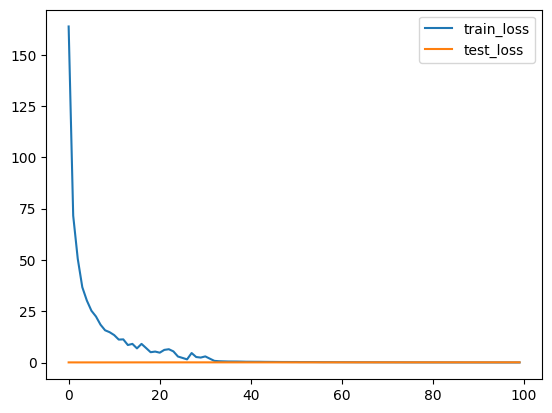

In [12]:
import pandas as pd
results = pd.DataFrame([])
results['train_loss']  = train_record
results['test_loss']  = test_record
results.plot.line(y=['train_loss', 'test_loss'])